In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

<h1 style="color:cyan;">Model 1</h1>

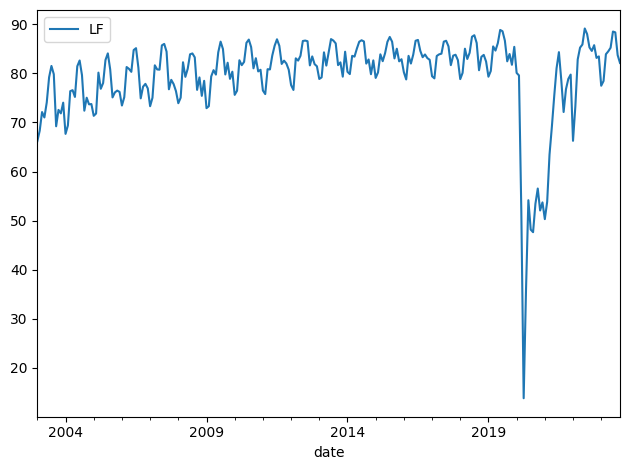

In [3]:
df = pd.read_csv('air traffic.csv')
df['date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))

series = pd.concat([df.iloc[:, -1], df['LF']], axis=1).set_index(df['date']).drop('date', axis=1)
series.plot()
plt.tight_layout()
plt.show()

In [4]:
# create a difference transform of the dataset
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
        
    return np.array(diff)
 
# Make a prediction give regression coefficients and lag obs
def predict(coef, history):
    yhat = coef[0]
    for i in range(1, len(coef)):
        yhat += coef[i] * history[-i]
        
    return yhat

In [5]:
X = difference(series.values)

In [6]:
size = int(len(X) * 0.82) + 1
train, test = X[0:size], X[size:]

In [7]:
size, train.shape, test.shape

(204, (204, 1), (44, 1))

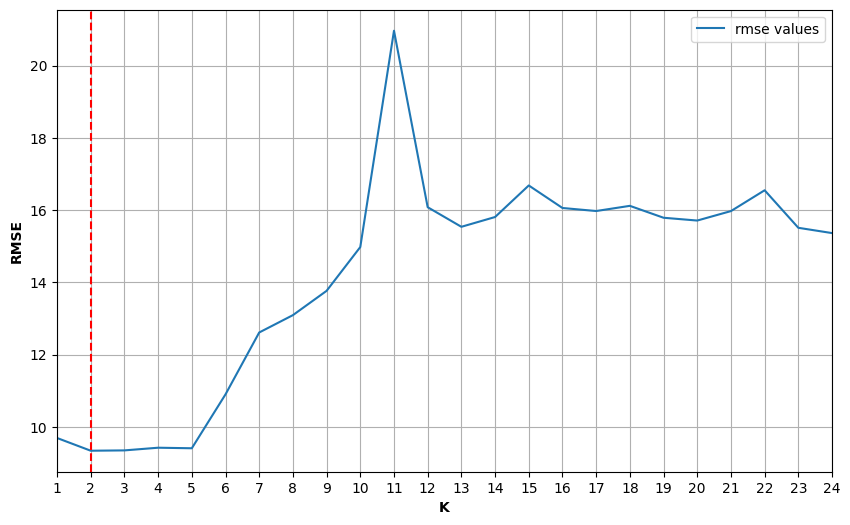

In [8]:
import numpy as np

# train autoregression
rmse_list = []
window_list = []
windows = 24
for i in range(1, windows+1):
    window = i
    model = AutoReg(train, lags=window)
    model_fit = model.fit()
    coef = model_fit.params

    # walk forward over time steps in test
    history = [train[i] for i in range(len(train))]
    predictions = list()
    for t in range(len(test)):
        yhat = predict(coef, history)
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)
    rmse = sqrt(mean_squared_error(test, predictions))
    window_list.append(window)
    rmse_list.append(rmse)

plt.figure(figsize=(10, 6))
plt.plot(window_list, rmse_list, label='rmse values')
plt.xlabel('K', weight='bold')
plt.ylabel('RMSE', weight='bold')
plt.axvline(x=window_list[rmse_list.index(min(rmse_list))], linestyle='--', c='red')
plt.xlim((1, 24))
plt.grid()
plt.xticks(np.arange(1, 25))
plt.legend()
plt.show()

Test RMSE: 9.342 for k = 2


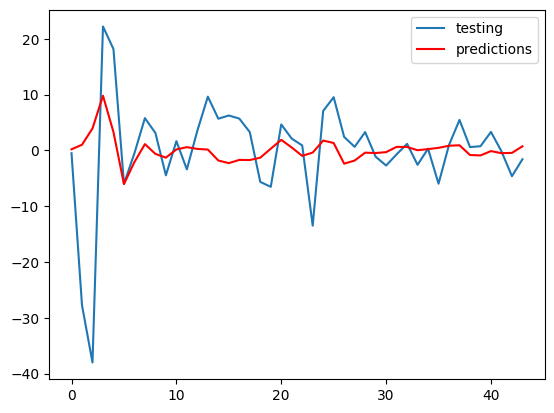

In [9]:
# plot
window = window_list[rmse_list.index(min(rmse_list))]
model = AutoReg(train, lags=window)
model_fit = model.fit()
coef = model_fit.params

# walk forward over time steps in test
history = [train[i] for i in range(len(train))]
predictions = list()
for t in range(len(test)):
    yhat = predict(coef, history)
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    
    #print('predicted=%f, expected=%f' % (yhat, obs))
    
rmse = sqrt(mean_squared_error(test, predictions))

print('Test RMSE: %.3f for k = %i' % (min(rmse_list), window))

plt.plot(test, label='testing')
plt.plot(predictions, color='red', label='predictions')
plt.legend()
plt.show()

<h1 style="color:cyan;">Model 2</h1>

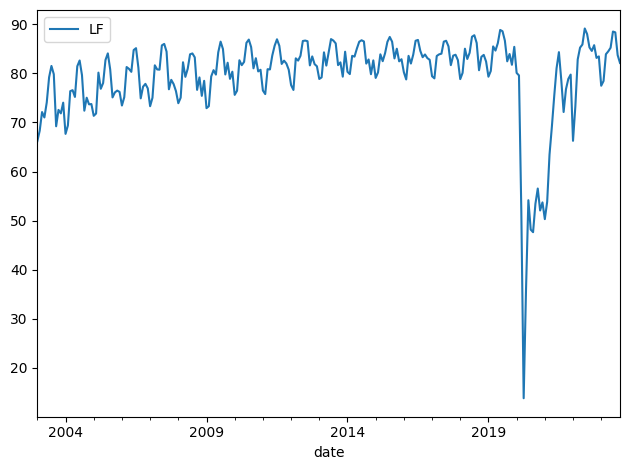

In [10]:
df = pd.read_csv('air traffic.csv')
df['date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))

series = pd.concat([df.iloc[:, -1], df['LF']], axis=1).set_index(df['date']).drop('date', axis=1)
series.plot()
plt.tight_layout()
plt.show()

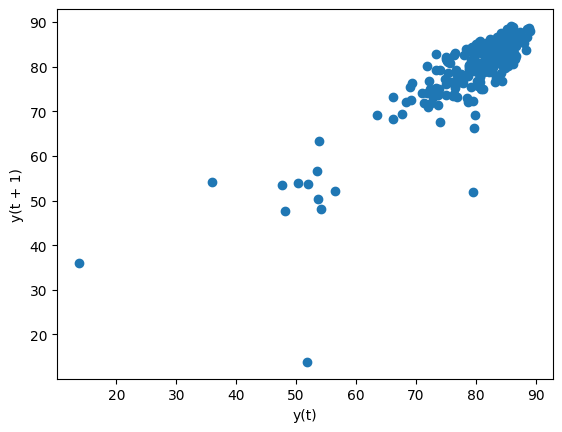

In [11]:
from pandas.plotting import lag_plot

lag_plot(series)
plt.show()

In [12]:
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.848614
t+1  0.848614  1.000000


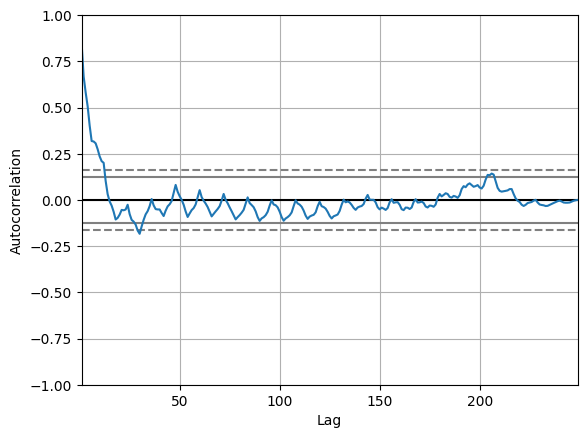

In [13]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)
plt.show()

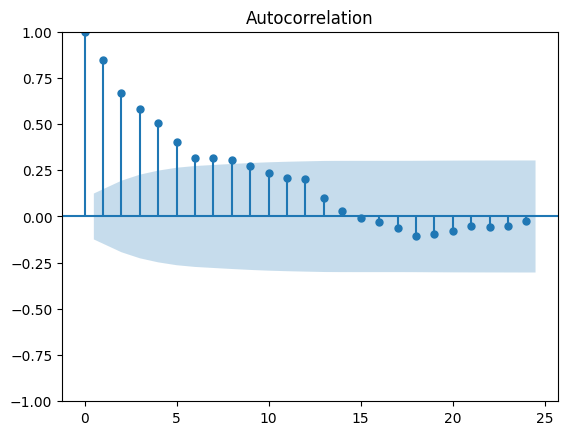

In [14]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(series, lags=24)
plt.show()

### Persistence Model

In [15]:
# create lagged dataset
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']

dataframe.head()

,t-1,t+1
0,NaN,66.20
1,66.20,68.31
2,68.31,72.12
3,72.12,71.02
4,71.02,74.07


In [16]:
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-45], X[len(X)-45:] # testing for 7 values, predictions
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [17]:
train.shape, test.shape

((203, 2), (45, 2))

In [18]:
# persistence model
def model_persistence(x):
    return x

# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
    
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)

Test MSE: 87.929


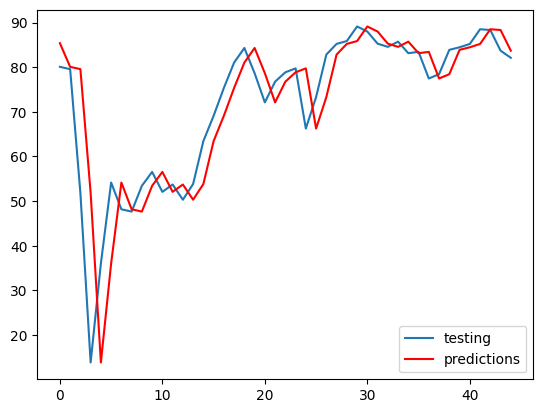

In [19]:
# plot predictions vs expected
plt.plot(test_y, label='testing')
plt.plot(predictions, color='red', label='predictions')
plt.legend()
plt.show()

### Autoregression Model

In [20]:
# split dataset
X = series.values
train, test = X[1:len(X)-45], X[len(X)-45:]

# train autoregression
model = AutoReg(train, lags=29)
model_fit = model.fit()

In [21]:
len(train), len(test)

(203, 45)

In [22]:
print('Coefficients: %s' % model_fit.params)

Coefficients: [ 9.52521986e+00  2.72034054e-01  2.20019496e-01  2.79581097e-02
  1.64321490e-01 -1.23023991e-01 -5.75480534e-02  1.10565516e-01
 -8.29978773e-02 -3.98979740e-02 -1.02633197e-02  1.14473025e-01
  6.11886019e-01 -2.11367130e-01 -4.41032956e-02 -5.53711576e-02
 -1.47634597e-01  1.72596671e-02 -1.54822856e-02 -8.52823680e-02
  4.91128260e-02  7.58636611e-02 -4.69941669e-03 -8.87656852e-02
  2.29428861e-01 -9.17573640e-03 -1.53842640e-01  2.36032085e-02
  2.13516722e-03  9.79686418e-02]


In [23]:
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f, diff=%f' % (predictions[i], test[i], predictions[i]-test[i]))

predicted=79.956726, expected=80.090000, diff=-0.133274
predicted=81.225719, expected=79.580000, diff=1.645719
predicted=85.315248, expected=51.830000, diff=33.485248
predicted=85.393268, expected=13.830000, diff=71.563268
predicted=85.835621, expected=36.020000, diff=49.815621
predicted=87.877254, expected=54.160000, diff=33.717254
predicted=88.736008, expected=48.170000, diff=40.566008
predicted=86.771531, expected=47.650000, diff=39.121531
predicted=82.296732, expected=53.430000, diff=28.866732
predicted=83.194169, expected=56.540000, diff=26.654169
predicted=82.790913, expected=52.070000, diff=30.720913
predicted=84.199572, expected=53.720000, diff=30.479572
predicted=79.563487, expected=50.310000, diff=29.253487
predicted=81.216738, expected=53.830000, diff=27.386738
predicted=85.359139, expected=63.450000, diff=21.909139
predicted=85.079691, expected=69.120000, diff=15.959691
predicted=85.487616, expected=75.360000, diff=10.127616
predicted=87.702692, expected=81.050000, diff=6.6

Test RMSE: 20.825


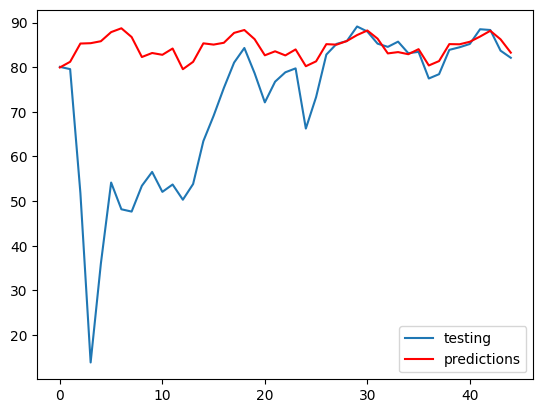

In [24]:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
plt.plot(test_y, label='testing')
plt.plot(predictions, color='red', label='predictions')
plt.legend()
plt.show()

### Other approach

In [25]:
# split dataset
X = series.values
train, test = X[1:len(X)-45], X[len(X)-45:]

In [26]:
len(train), len(test)

(203, 45)

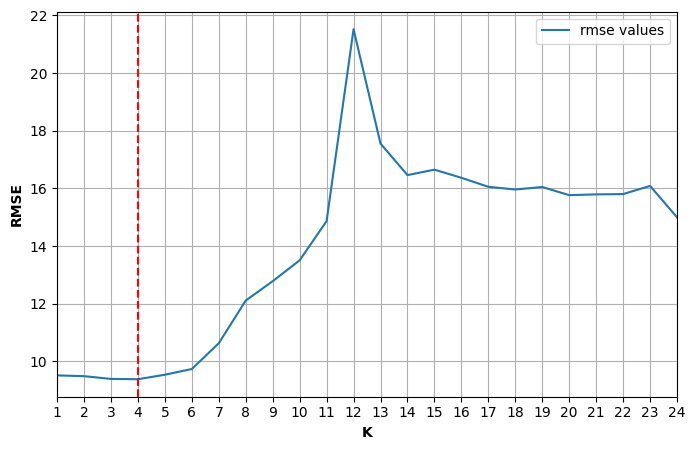

In [27]:
rmse_list = []
window_list = []
windows = 24

for i in range(1, windows+1):
    window = i
    model = AutoReg(train, lags=window)
    model_fit = model.fit()
    coef = model_fit.params

    # walk forward over time steps in test
    history = train[len(train) - window:]
    history = [history[i] for i in range(len(history))]
    predictions = list()

    for t in range(len(test)):
        length = len(history)
        lag = [history[i] for i in range(length-window, length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)
    
    rmse_list.append(sqrt(mean_squared_error(test, predictions)))
    window_list.append(window)
        
plt.figure(figsize=(8, 5))
plt.plot(window_list, rmse_list, label='rmse values')
plt.xlabel('K', weight='bold')
plt.ylabel('RMSE', weight='bold')
plt.axvline(x=window_list[rmse_list.index(min(rmse_list))], linestyle='--', c='red')
plt.xlim((1, 24))
plt.grid()
plt.xticks(np.arange(1, 25))
plt.legend()
plt.show()

Min Test RMSE: 9.376


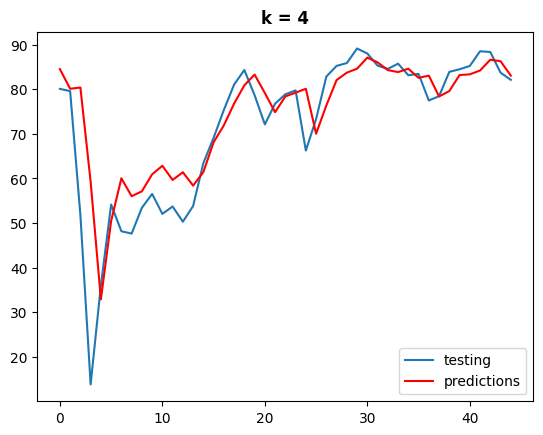

In [28]:
# train autoregression
window = 4
model = AutoReg(train, lags=window)
model_fit = model.fit()
coef = model_fit.params

# walk forward over time steps in test
history = train[len(train) - window:]
history = [history[i] for i in range(len(history))]
predictions = list()

for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window, length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
        
    #print('predicted=%f, expected=%f' % (yhat, obs))
    
rmse = sqrt(mean_squared_error(test, predictions))
print('Min Test RMSE: %.3f' % rmse)
# plot
plt.plot(test_y, label='testing')
plt.plot(predictions, color='red', label='predictions')
plt.title(f'k = {window}', weight='bold')
plt.legend()
plt.show()

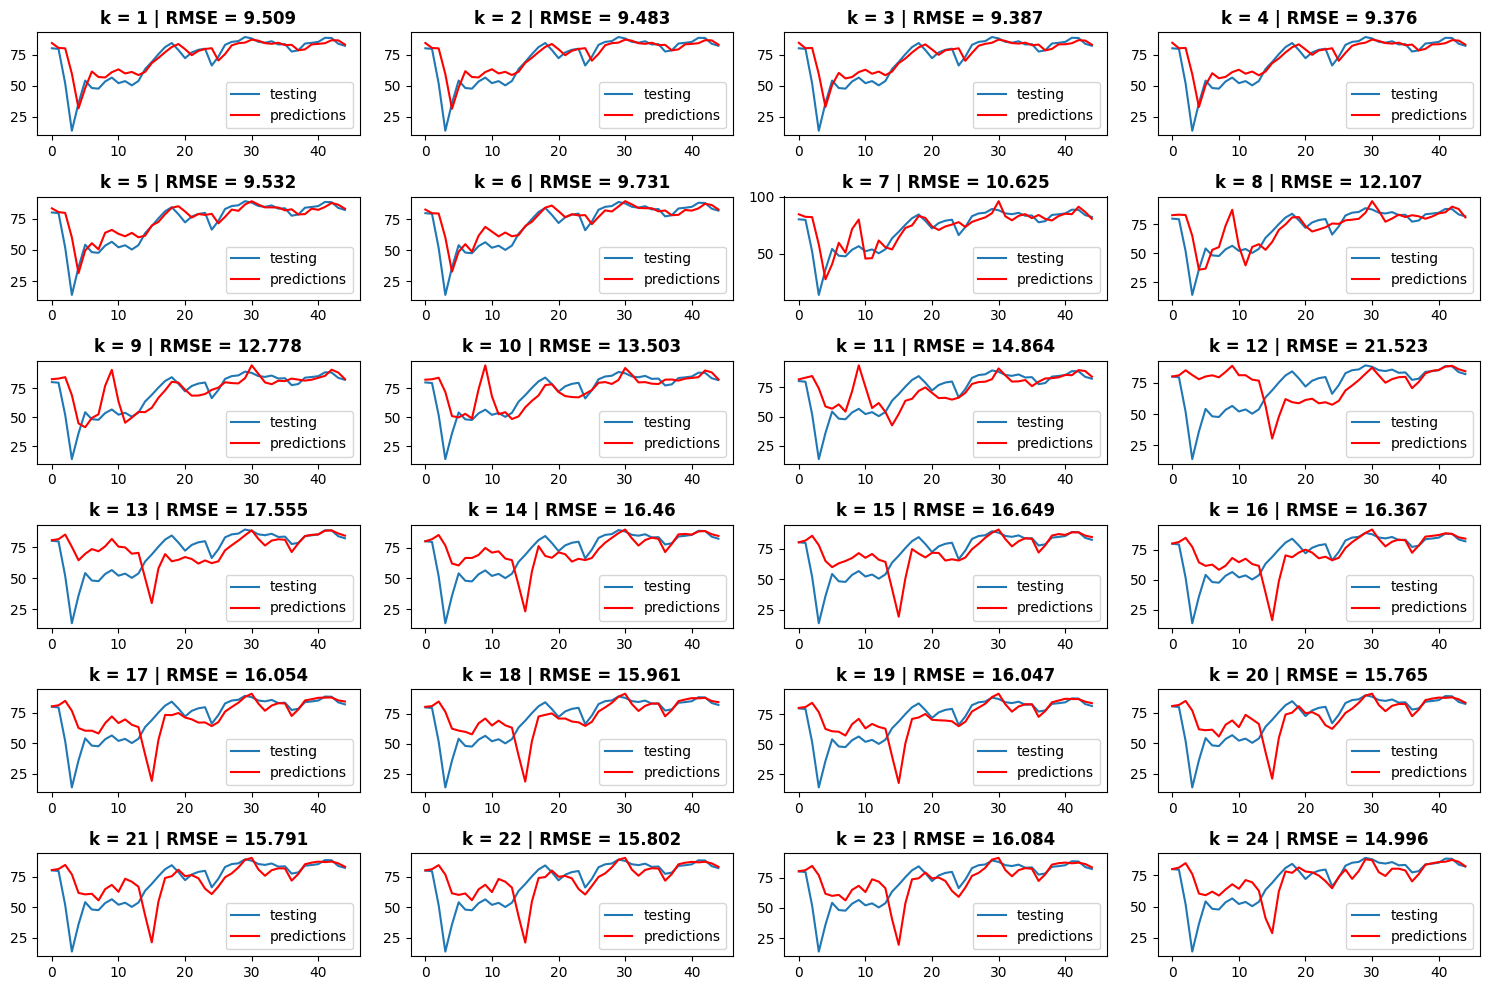

In [29]:
fig, ax = plt.subplots(6, 4, figsize=(15, 10))

i = 1
for nr in range(6):
    for nc in range(4):
        window = i
        model = AutoReg(train, lags=window)
        model_fit = model.fit()
        coef = model_fit.params

        # walk forward over time steps in test
        history = train[len(train) - window:]
        history = [history[i] for i in range(len(history))]
        predictions = list()

        for t in range(len(test)):
            length = len(history)
            lag = [history[i] for i in range(length-window, length)]
            yhat = coef[0]
            for d in range(window):
                yhat += coef[d+1] * lag[window-d-1]
            
            obs = test[t]
            predictions.append(yhat)
            history.append(obs)
                
            #print('predicted=%f, expected=%f' % (yhat, obs))
        i += 1
            
        rmse = round(sqrt(mean_squared_error(test, predictions)), 3)
        #print('Min Test RMSE: %.3f' % rmse)
        # plot
        ax[nr][nc].plot(test_y, label='testing')
        ax[nr][nc].plot(predictions, color='red', label='predictions')
        ax[nr][nc].set_title(f'k = {window} | RMSE = {rmse}', weight='bold')
        ax[nr][nc].legend()

plt.tight_layout()
plt.show()

## Data Normalization

In [45]:
X = dataframe.values
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
X_norm = (X - X.min()) / (X.max() - X.min())

train_norm, test_norm = X_norm[1:len(X_norm)-45], X_norm[len(X_norm)-45:]
train_X_norm, train_y_norm = train_norm[:,0], train_norm[:,1]
test_X_norm, test_y_norm = test_norm[:,0], test_norm[:,1]

train_norm.shape, test_norm.shape

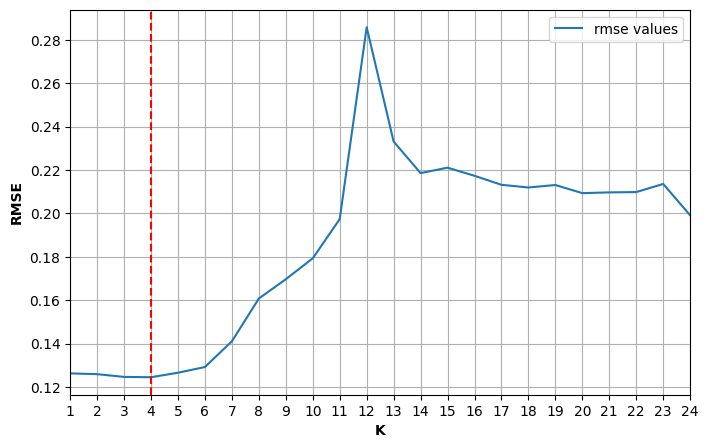

In [37]:
rmse_list = []
window_list = []
windows = 24

for i in range(1, windows+1):
    window = i
    model = AutoReg(train_norm, lags=window)
    model_fit = model.fit()
    coef = model_fit.params

    # walk forward over time steps in test_norm
    history = train_norm[len(train_norm) - window:]
    history = [history[i] for i in range(len(history))]
    predictions = list()

    for t in range(len(test_norm)):
        length = len(history)
        lag = [history[i] for i in range(length-window, length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        
        obs = test_norm[t]
        predictions.append(yhat)
        history.append(obs)
    
    rmse_list.append(sqrt(mean_squared_error(test_norm, predictions)))
    window_list.append(window)
        
plt.figure(figsize=(8, 5))
plt.plot(window_list, rmse_list, label='rmse values')
plt.xlabel('K', weight='bold')
plt.ylabel('RMSE', weight='bold')
plt.axvline(x=window_list[rmse_list.index(min(rmse_list))], linestyle='--', c='red')
plt.xlim((1, 24))
plt.grid()
plt.xticks(np.arange(1, 25))
plt.legend()
plt.show()